# Rassemble et tri les journées de promotions selon leurs exigences -------
# *Théo JAOUDET*

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
import getpass
import time
import re
from bs4 import BeautifulSoup

# OUVERTURE SITE LDV

In [2]:
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.set_window_size(1024, 600)
driver.maximize_window()
driver.get("https://www.leonard-de-vinci.net/")

<ipython-input-2-01a8119236d5>:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


REMPLISSAGE PREMIERE PAGE MAIL

In [3]:
time.sleep(1)
mail = "" ###A RENSEIGNER
driver.find_element('id',"login").send_keys(mail)
driver.find_element('xpath',"//*[@id=\"btn_next\"]").click()

REMPLISSAGE DEUXIEME PAGE MDP + LOGIN

In [4]:
time.sleep(1)
password = "" ###A RENSEIGNER
driver.find_element('id',"passwordInput").send_keys(password)
driver.find_element('id',"submitButton").click()

OUVERTURE ONGLET PROMOTIONS

In [5]:
time.sleep(1)
driver.find_element('xpath',"//*[@id=\"accordion2\"]/div[6]/div/a").click()

RECHERCHE DES PROMOTIONS

In [6]:
time.sleep(1)
page_source = driver.page_source
soup = BeautifulSoup(page_source, 'lxml')
elements = soup.find_all('div',"media social-box")
l = []
for i in elements:
    i = i.text.replace('\n',' ')
    i = i.replace('\t',' ')
    l.append(i.strip())
c = 1
for i in l:
    #print("EVENEMENT NUM ",c,"-->",i)
    c+=1

FERMETURE DE LA PAGE INTERNET

In [7]:
driver.quit()

# SERIE DE TRANSFORMATIONS DES DONNEES RECOLTEES

In [8]:
listEl =[]
#Crée une liste de listes propre
for e in l:
    a = str(e)
    a = a.replace(u'\xa0', u' ')
    a = a.split("\n")  
    listEl.append(a)

#Liste utile pour chercher les données
jours = ['lundi','mardi','mercredi','jeudi','vendredi','samedi','dimanche']
    
#Types de données à extraire
type_p = []
urgent =[]
date = []
heure =[]
ecole = []
adresse =[]
pays =[]
ville =[]
codepostal =[]
public =[]
demande =[]
inscrit =[]
restant =[]
commentaires =[]
statut=[]


for i in range(1,len(listEl)):
    a = (listEl[i][0]).replace(':',' ').replace('de',' ').replace(',',' ') #Enleve caract inutiles
    a = a.split() #Découpe chaque liste en listes
    
    ###Verification si évènement urgent
    decalageU = 0
    urgentM =""
    if 'événement' in a:
        urgentM =a[2]+a[3]
        decalageU = 5
    else:
        urgentM = 'Non'
    urgent.append(urgentM)
    
    ###Ajout type promo
    type_p.append(a[0+decalageU])
    
    ###Ajout date promo
    indexD=0
    for j in jours:
        for t in range(0,len(a)):
            if j == a[t]:
                indexD = a.index(j)           
    date.append(a[indexD]+' '+a[indexD+1]+' '+a[indexD+2] + ' '  +a[indexD+3])
    
    ###Ajout de l'heure
    indexH = indexD+4
    heure.append(a[indexH]+' '+a[indexH+1]+' '+a[indexH+2]+' '+a[indexH+3]+' '+a[indexH+4])
    
    ###Ajout nom lycée
    if a[0]=='FORUM':
        indexL = 3
        lycee=""
        for t in range(indexL,indexD):
            lycee += a[t] +' '
        ecole.append(lycee)
    else:
        ecole.append('ESILV')
        
    ###Ajout adresse
    indexA = indexH+5
    t=0
    adresseS = ""
    
    #CAS SPECIAL JPO ONLINE
    if 'ONLINE' in a:
        a.insert(indexA,'ONLINE')
        a.insert(indexA+1,"00000")
        a.insert(indexA+2,"ONLINE")
    
    while (a[indexA+t].isnumeric()==False) or (len(a[indexA+t])<4): #Arrêt au code postal
        if 'LUXEMBOURG' in a: #CAS SPECIAL LUXEMBOURG
            adresseS = "1-3 rue Albert Einstein"
            indexA = a.index('L-1484')
            t=0
            break
        else:
            if indexA+t+1 == len(a): #CAS SPECIAL PB DS LES DONNEES
                adresseS =a[indexA]+' '+a[indexA+1]+' '+a[indexA+2]
                t=3
                break
            adresseS += a[indexA+t] +' ' #CAS NORMAL
            t+=1
    adresse.append(adresseS)
    
    #CAS CAMPUS ONLINE, AJOUT INFOS MANQUANTES
    if(adresseS[:6]=='Campus'):
        a.insert(20,'92400')
        a.insert(21,'COURBEVOIE')
        
    
    ###Ajout code postal
    codepostal.append(a[indexA+t])
    
    ###Ajout ville
    indexF = 0
    villeS =""
    
    if ('FRANCE' not in a) and (len(a[indexA+t])==4 or len(a[indexA+t])==5) and (a[indexA+t].isnumeric()==True): #Ajout FRANCE aux écoles manquantes
        indexP = a.index('Public')
        a.insert(indexP,'FRANCE')
    
    for p in range(indexA+t+1,len(a)-1): #Prise de l'index du mot FRANCE dans la liste
        if a[p]=='FRANCE':
            indexF = p
    if indexF==0: #CAS OU FRANCE N'EST PAS DANS LA LISTE
        indexF = indexA+t+2
    for u in range(indexA+t+1,indexF): #Ajout du nom complet de la ville
        villeS += a[u] +' '
    ville.append(villeS)
    
    ###Ajout pays
    pays.append(a[indexF])

    ###Ajout public rencontré
    if 'rencontré' in a: #Cas d'un forum
        indexR = a.index('rencontré')
        indexO = a.index('Organisation')
        rencontre=""
        for t in range(indexR+1,indexO):
            rencontre += a[t] + ' '
        public.append(rencontre)
    else: #Autres types d'actions
        public.append('Tous types')
    
    ###Ajout organisation
    indexC= 0
    if 'managers' in a: #Cas avec orga détaillée
        indexO = a.index('Organisation')
        indexm = a.index('managers')
        indexM = a.index('Manager')
        indexD = a.index('Deman')
        dem =""
        ins=""
        rest =""
        for t in range(indexO+1,indexm+1):
            dem += a[t] +' '
        demande.append(dem)
        for t in range(indexm+2,indexM+2):
            ins +=a[t]+' '
        inscrit.append(ins)
        for t in range(indexM+4,indexD):
            rest += a[t] +' '
        restant.append(rest)
        indexC = a.index('Deman')
        
    else: #Cas avec orga simple
        indexO = a.index('Organisation')
        demande.append(a[indexO+1])
        inscrit.append(a[indexO+5])
        restant.append(a[indexO+9])
        indexC = indexO+10
        
    ###Ajout commentaires
    indexD = a.index('Deman')
    com = ""
    for t in range(indexC,indexD):
        com += a[t] +' '
    commentaires.append(com)
    
    ###Ajout état demande
    stat = " ".join(a[-2:])
    statut.append(stat)
    

In [9]:
import pandas as pd
df=  pd.DataFrame(list(zip(type_p, urgent, date,heure,ecole,adresse,codepostal,ville,pays,
                           public,demande,inscrit,restant,commentaires, statut)),
                  columns=['Type', 'Urgent', 'Date','Heure','Ecole','Adresse',
                           'Code_Postal','Ville','Pays','Public_rencontré',
                           'Demande','Inscrits','Restant','Commentaires','Statut'])

In [10]:
df = df.replace(to_replace="Public", value="FRANCE")
df['Ville'] = df['Ville'].str.upper()

In [11]:
from datetime import datetime
def helpDate(x): #Convertit mois FR en abrév. EN
    if x=='janvier':
        return 'Jan'
    elif x=='février':
        return 'Feb'
    elif x=='mars':
        return 'Mar'
    elif x=='avril':
        return 'Apr'
    elif x=='mai':
        return 'May'
    elif x=='juin':
        return 'Jun'
    elif x=='juillet':
        return 'July'
    elif x=='août':
        return 'Aug'
    elif x=='septembre':
        return 'Sept'
    elif x=='octobre':
        return 'Oct'
    elif x=='novembre':
        return 'Nov'
    elif x=='décembre':
        return 'Dec'
def convLang(x): #Convertit date au format simplifié
    date = ""
    x = x.split()
    x = x[1:] #Enlève le jour de la semaine
    d = x[0] #No change
    m = helpDate(x[1])
    a = x[2]
    date = d+' '+m+' '+a
    return date
def convDate(x):
    dateFormatter = "%d %b %Y"
    return datetime.strptime(str(x), dateFormatter)

In [12]:
df['Date'] = df['Date'].map(convLang)
df['Date'] = df['Date'].map(convDate)

In [13]:
df

,Type,Urgent,Date,Heure,Ecole,Adresse,Code_Postal,Ville,Pays,Public_rencontré,Demande,Inscrits,Restant,Commentaires,Statut
0,ORGANISATION,3jours,2023-02-02,08 00 à 13 00,ESILV,Pôle Léonard Vinci,92400,COURBEVOIE,FRANCE,Tous types,10,0,10,Il y aura essentiellement la manutention donc ...,Deman participation
1,ORGANISATION,4jours,2023-02-03,08 00 à 12 00,ESILV,Pôle Léonard Vinci,92400,COURBEVOIE,FRANCE,Tous types,10,0,10,,Deman participation
2,FORUM,4jours,2023-02-03,09 00 à 16 30,ESILV,1 boulevard la Marne,89015,AUXERRE,FRANCE,SECONDE1ERETERMINALE ANCIENS UNIQUEMENT,2,0,2,,Deman participation
3,FORUM,4jours,2023-02-03,16 00 à 20 00,ESILV,1 rue Constant Pilate,92331,SCEAUX,FRANCE,1ERETERMINALECPGE_ECONOMIQUE_ET_COMMERCIALE AN...,2,0,2,,Deman participation
4,SALON,5jours,2023-02-04,09 00 à 18 00,ESILV,Parc s expositions - Porte Versailles,75015,PARIS,FRANCE,Tous types,11 étudiants dont 2 experts dont 2 managers,Total 10 Expert 1 Manager 0,Total 1 Expert 1 Manager 2,,Deman participation
5,FORUM,5jours,2023-02-04,08 00 à 13 00,ESILV,23 Chemin Vert Boissy,95150,TAVERNY,FRANCE,SECONDE1ERETERMINALE,2,1,1,,Deman participation
6,FORUM,5jours,2023-02-04,13 40 à 17 30,ESILV,Avenue Erasme Rond Point l'Europe,77330,OZOIR LA FERRI?RE,FRANCE,SECONDE1ERETERMINALE,2,1,1,,Deman participation
7,FORUM,5jours,2023-02-04,08 00 à 12 30,ESILV,32 avenue Montaigne,93165,NOISY LE GRAND,FRANCE,1ERETERMINALE ANCIENS UNIQUEMENT,2,1,1,,Deman participation
8,FORUM,5jours,2023-02-04,09 00 à 12 00,ESILV,74 rue Georges Clemenceau,77220,TOURNAN-EN-BRIE,FRANCE,1ERETERMINALE,2,0,2,,Deman participation
9,SALON,6jours,2023-02-05,09 00 à 18 00,ESILV,Parc s expositions - Porte Versailles,75015,PARIS,FRANCE,Tous types,10 étudiants dont 2 experts dont 2 managers,Total 8 Expert 2 Manager 0,Total 2 Expert 0 Manager 2,,Deman participation


<AxesSubplot:xlabel='Public_rencontré'>

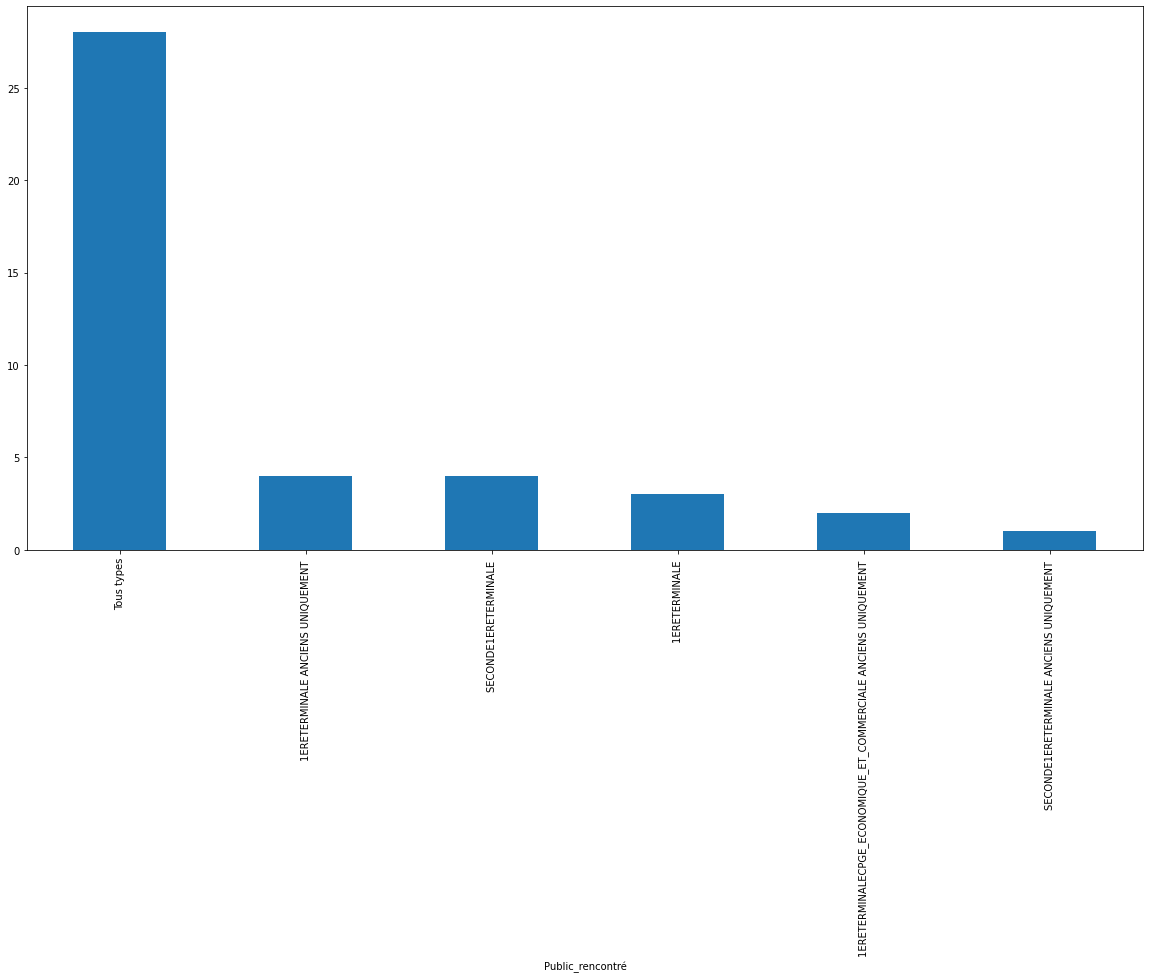

In [14]:
a = df.groupby('Public_rencontré').count().sort_values(by='Type',ascending=False)
a['Type'].plot(kind='bar',figsize=(20,10))

In [15]:
df.groupby('Demande').count().sort_values(by='Type',ascending=False)

,Type,Urgent,Date,Heure,Ecole,Adresse,Code_Postal,Ville,Pays,Public_rencontré,Inscrits,Restant,Commentaires,Statut
Demande,,,,,,,,,,,,,,
2,29,29,29,29,29,29,29,29,29,29,29,29,29,29
10,5,5,5,5,5,5,5,5,5,5,5,5,5,5
15,3,3,3,3,3,3,3,3,3,3,3,3,3,3
10 étudiants dont 2 experts dont 2 managers,1,1,1,1,1,1,1,1,1,1,1,1,1,1
11 étudiants dont 2 experts dont 2 managers,1,1,1,1,1,1,1,1,1,1,1,1,1,1
26,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1
70 étudiants dont 20 experts dont 15 managers,1,1,1,1,1,1,1,1,1,1,1,1,1,1
